## Programming project: probability of death

In this project, you have to predict the probability of death of a patient that is entering an ICU (Intensive Care Unit).

The dataset comes from MIMIC project (https://mimic.physionet.org/). MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Each row of *mimic_train.csv* correponds to one ICU stay (*hadm_id*+*icustay_id*) of one patient (*subject_id*). Column HOSPITAL_EXPIRE_FLAG is the indicator of death (=1) as a result of the current hospital stay; this is the outcome to predict in our modelling exercise.
The remaining columns correspond to vitals of each patient (when entering the ICU), plus some general characteristics (age, gender, etc.), and their explanation can be found at *mimic_patient_metadata.csv*. 

Please don't use any feature that you infer you don't know the first day of a patient in an ICU.

Note that the main cause/disease of patient condition is embedded as a code at *ICD9_diagnosis* column. The meaning of this code can be found at *MIMIC_metadata_diagnose.csv*. **But** this is only the main one; a patient can have co-occurrent diseases (comorbidities). These secondary codes can be found at *extra_data/MIMIC_diagnoses.csv*.

As performance metric, you can use *AUC* for the binary classification case, but feel free to report as well any other metric if you can justify that is particularly suitable for this case.

Main tasks are:
+ Using *mimic_train.csv* file build a predictive model for *HOSPITAL_EXPIRE_FLAG* .
+ For this analysis there is an extra test dataset, *mimic_test_death.csv*. Apply your final model to this extra dataset and generate predictions following the same format as *mimic_kaggle_death_sample_submission.csv*. Once ready, you can submit to our Kaggle competition and iterate to improve the accuracy.

As a *bonus*, try different algorithms for neighbor search and for distance, and justify final selection. Try also different weights to cope with class imbalance and also to balance neighbor proximity. Try to assess somehow confidence interval of predictions.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Manage missing data.
2. Manage categorial features. E.g. create *dummy variables* for relevant categorical features, or build an ad hoc distance function.
3. Build a prediction model.
5. Assess expected accuracy and tune your models using *cross-validation*. 
6. Test the performance on the test file and report accuracy, following same preparation steps (missing data, dummies, etc). Remember that you should be able to yield a prediction for all the rows of the test dataset.

Feel free to reduce the training dataset if you experience computational constraints.

## Main criteria for IN_CLASS grading
The weighting of these components will vary between the in-class and extended projects:
+ Code runs - 20%
+ Data preparation - 35%
+ Nearest neighbor method(s) have been used - 15%
+ Probability of death for each test patient is computed - 10%
+ Accuracy of predictions for test patients is calculated (kaggle) - 10%
+ Hyperparameter optimization - 10%
+ Neat and understandable code, with some titles and comments - 0%
+ Improved methods from what we discussed in class (properly explained/justified) - 0%

In [46]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.svm import SVC, SVR
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
#from utils.helper_functions import *
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
import numpy as np
## Modules for constructing Pipelines
#from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
#from pipelinehelper import PipelineHelper
## Modules for scalers, imputers and encoders 
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.decomposition import PCA
from numpy import random
from sklearn import svm

In [47]:
def GridSearch_table_plot(grid_clf, param_name,
                          num_results=15,
                          negative=True,
                          graph=True,
                          display_all_params=True):

    '''Display grid search results

    Arguments
    ---------

    grid_clf           the estimator resulting from a grid search
                       for example: grid_clf = GridSearchCV( ...

    param_name         a string with the name of the parameter being tested

    num_results        an integer indicating the number of results to display
                       Default: 15

    negative           boolean: should the sign of the score be reversed?
                       scoring = 'neg_log_loss', for instance
                       Default: True

    graph              boolean: should a graph be produced?
                       non-numeric parameters (True/False, None) don't graph well
                       Default: True

    display_all_params boolean: should we print out all of the parameters, not just the ones searched for?
                       Default: True

    Usage
    -----

    GridSearch_table_plot(grid_clf, "min_samples_leaf")

                          '''
    from matplotlib      import pyplot as plt
    from IPython.display import display
    import pandas as pd

    clf = grid_clf.best_estimator_
    clf_params = grid_clf.best_params_
    if negative:
        clf_score = -grid_clf.best_score_
    else:
        clf_score = grid_clf.best_score_
    clf_stdev = grid_clf.cv_results_['std_test_score'][grid_clf.best_index_]
    cv_results = grid_clf.cv_results_

    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    if display_all_params:
        import pprint
        pprint.pprint(clf.get_params())

    # pick out the best results
    # =========================
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')

    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row['param_' + param_name]

    # display the top 'num_results' results
    # =====================================
    display(pd.DataFrame(cv_results) \
            .sort_values(by='rank_test_score').head(num_results))

    # plot the results
    # ================
    scores_df = scores_df.sort_values(by='param_' + param_name)

    if negative:
        means = -scores_df['mean_test_score']
    else:
        means = scores_df['mean_test_score']
    stds = scores_df['std_test_score']
    params = scores_df['param_' + param_name]

    # plot
    if graph:
        plt.figure(figsize=(8, 8))
        plt.errorbar(params, means, yerr=stds)

        plt.axhline(y=best_mean + best_stdev, color='red')
        plt.axhline(y=best_mean - best_stdev, color='red')
        plt.plot(best_param, best_mean, 'or')

        plt.title(param_name + " vs Score\nBest Score {:0.5f}".format(clf_score))
        plt.xlabel(param_name)
        plt.ylabel('Score')
        plt.show()

Read Train Dataset and select a random "piece" of the dataset to train the model later.

In [48]:
train=pd.read_csv('mimic_train.csv')
test=pd.read_csv('mimic_test_death.csv')

In [49]:
print(train.shape)
print(test.shape)

(20885, 44)
(5221, 39)


Removing unnecesary features

In [50]:
rem_vars = ['DOD', 'DISCHTIME', 'DEATHTIME'] 
y_var  ='HOSPITAL_EXPIRE_FLAG'
train.drop(columns=rem_vars, inplace=True)

Drop columns that contain 70% or more of nulls

In [51]:
limitPer = len(train) * .70
train.dropna(thresh=limitPer, axis=1, inplace=True)
test = test[train.columns[train.columns != y_var ]]

Checking dataset after removing columns with majority of NANs

In [52]:
train.isnull().sum()

HOSPITAL_EXPIRE_FLAG       0
subject_id                 0
hadm_id                    0
icustay_id                 0
HeartRate_Min           2187
HeartRate_Max           2187
HeartRate_Mean          2187
SysBP_Min               2208
SysBP_Max               2208
SysBP_Mean              2208
DiasBP_Min              2209
DiasBP_Max              2209
DiasBP_Mean             2209
MeanBP_Min              2186
MeanBP_Max              2186
MeanBP_Mean             2186
RespRate_Min            2189
RespRate_Max            2189
RespRate_Mean           2189
TempC_Min               2497
TempC_Max               2497
TempC_Mean              2497
SpO2_Min                2203
SpO2_Max                2203
SpO2_Mean               2203
Glucose_Min              253
Glucose_Max              253
Glucose_Mean             253
GENDER                     0
DOB                        0
ADMITTIME                  0
Diff                       0
ADMISSION_TYPE             0
INSURANCE                  0
RELIGION      

DIAGNOSIS: Extract how many patients die and how many live for each diagnosis to calculate probability of death.

In [53]:
dead = train[train['HOSPITAL_EXPIRE_FLAG'] == 1]
not_dead = train[train['HOSPITAL_EXPIRE_FLAG'] == 0]
dead_df = pd.DataFrame(dead['DIAGNOSIS'].value_counts())
not_dead_df = pd.DataFrame(not_dead['DIAGNOSIS'].value_counts())
dead_df.rename(columns={'DIAGNOSIS': 'Diagnosis Count Dead'}, inplace=True)
not_dead_df.rename(columns={'DIAGNOSIS': 'Diagnosis Count Live'}, inplace=True)
dead_df['DIAGNOSIS'] = dead_df.index
not_dead_df['DIAGNOSIS'] = not_dead_df.index

train = pd.merge(train, dead_df, on='DIAGNOSIS', how='left')
train = pd.merge(train, not_dead_df, on='DIAGNOSIS', how='left')
test = pd.merge(test, dead_df, on='DIAGNOSIS', how='left')
test = pd.merge(test, not_dead_df, on='DIAGNOSIS', how='left')
train['Diagnosis Count Dead'] = train['Diagnosis Count Dead'].fillna(0)
train['Diagnosis Count Live'] = train['Diagnosis Count Live'].fillna(0)
test['Diagnosis Count Dead'] = test['Diagnosis Count Dead'].fillna(0)
test['Diagnosis Count Live'] = test['Diagnosis Count Live'].fillna(0)
train['Diagnosis Prob Death'] = train['Diagnosis Count Dead'] / (train['Diagnosis Count Dead']+train['Diagnosis Count Live']) 
test['Diagnosis Prob Death'] = test['Diagnosis Count Dead'] / (test['Diagnosis Count Dead']+test['Diagnosis Count Live'])
train.drop(columns=['Diagnosis Count Dead','Diagnosis Count Live'], axis=1, inplace=True)
test.drop(columns=['Diagnosis Count Dead','Diagnosis Count Live'], axis=1, inplace=True)

ICD9_diagnosis: same process as DIAGNOSIS

In [54]:
dead = train[train['HOSPITAL_EXPIRE_FLAG'] == 1]
not_dead = train[train['HOSPITAL_EXPIRE_FLAG'] == 0]
dead_df = pd.DataFrame(dead['ICD9_diagnosis'].value_counts())
not_dead_df = pd.DataFrame(not_dead['ICD9_diagnosis'].value_counts())
dead_df.rename(columns={'ICD9_diagnosis': 'ICD9_Diagnosis Count Dead'}, inplace=True)
not_dead_df.rename(columns={'ICD9_diagnosis': 'ICD9_Diagnosis Count Live'}, inplace=True)
dead_df['ICD9_diagnosis'] = dead_df.index
not_dead_df['ICD9_diagnosis'] = not_dead_df.index

train = pd.merge(train, dead_df, on='ICD9_diagnosis', how='left')
train = pd.merge(train, not_dead_df, on='ICD9_diagnosis', how='left')
test = pd.merge(test, dead_df, on='ICD9_diagnosis', how='left')
test = pd.merge(test, not_dead_df, on='ICD9_diagnosis', how='left')
train['ICD9_Diagnosis Count Dead'] = train['ICD9_Diagnosis Count Dead'].fillna(0)
train['ICD9_Diagnosis Count Live'] = train['ICD9_Diagnosis Count Live'].fillna(0)
test['ICD9_Diagnosis Count Dead'] = test['ICD9_Diagnosis Count Dead'].fillna(0)
test['ICD9_Diagnosis Count Live'] = test['ICD9_Diagnosis Count Live'].fillna(0)
train['ICD9_Diagnosis Prob Death'] = train['ICD9_Diagnosis Count Dead'] / (train['ICD9_Diagnosis Count Dead']+train['ICD9_Diagnosis Count Live']) 
test['ICD9_Diagnosis Prob Death'] = test['ICD9_Diagnosis Count Dead'] / (test['ICD9_Diagnosis Count Dead']+test['ICD9_Diagnosis Count Live'])
train.drop(columns=['ICD9_Diagnosis Count Dead','ICD9_Diagnosis Count Live'], axis=1, inplace=True)
test.drop(columns=['ICD9_Diagnosis Count Dead','ICD9_Diagnosis Count Live'], axis=1, inplace=True)

Drop non-numeric columns

In [55]:
nonnumeric = ['subject_id', 'hadm_id', 'icustay_id',
       'MARITAL_STATUS', 'ICD9_diagnosis', 'RELIGION', 'DIAGNOSIS']

test.drop(columns=nonnumeric, inplace=True)
train.drop(columns=nonnumeric, inplace=True)

Converting admit time from string to datetime and extract if the patient was admit at night (urgency)

In [56]:
train['ADMITTIME'] = pd.to_datetime(train['ADMITTIME'])
test['ADMITTIME'] = pd.to_datetime(test['ADMITTIME'])

train['month'] = train['ADMITTIME'].apply(lambda x: x.month)
train['year'] = train['ADMITTIME'].apply(lambda x: x.year)
train['hour'] = train['ADMITTIME'].apply(lambda x: x.hour)
test['month'] = test['ADMITTIME'].apply(lambda x: x.month)
test['year'] = test['ADMITTIME'].apply(lambda x: x.year)
test['hour'] = test['ADMITTIME'].apply(lambda x: x.hour)
train['night_entrance']=np.where((train['hour'] > 22) | (train['hour'] < 6) , 1, 0)
test['night_entrance']=np.where((test['hour'] > 22) | (test['hour'] < 6) , 1, 0)

Getting Age

In [57]:
train['Diff'] = train['Diff'].astype(int)
train['Diff'] = train.apply(lambda x: timedelta(days=-x.Diff),axis=1)
train['DOB'] = pd.to_datetime(train['DOB'])
train['DOB'] = train.apply(lambda x: (x.DOB.to_pydatetime() - x.Diff),axis=1)
train['year_age']= train.apply(lambda x: (x.DOB.year),axis=1)

test['Diff'] = test['Diff'].astype(int)
test['Diff'] = test.apply(lambda x: timedelta(days=-x.Diff),axis=1)
test['DOB'] = pd.to_datetime(test['DOB'])
test['DOB'] = test.apply(lambda x: (x.DOB.to_pydatetime() - x.Diff),axis=1)
test['year_age']= test.apply(lambda x: (x.DOB.year),axis=1)

In [58]:
drop_col = ['month', 'year', 'hour', 'ADMITTIME','DOB', 'Diff']
#drop_col = ['month', 'year', 'hour', 'ADMITTIME']
test.drop(columns=drop_col, inplace=True)
train.drop(columns=drop_col, inplace=True)

Check age outliers to remove

(20885, 34)


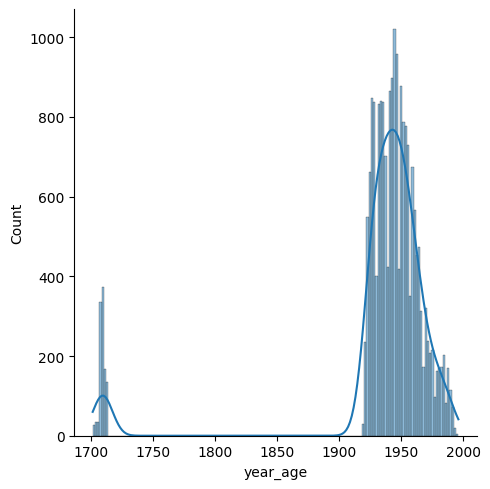

In [59]:
import seaborn as sns
sns.displot(train['year_age'], kde=True)
print(train.shape)

In [60]:
def IQs_outliers (col):

    Q2 = col.quantile(q=0.5)
    Q1 = col.quantile(q=0.25)
    Q3 = col.quantile(q=0.75)
    IQR = Q3 - Q2
    IQ_menor = round(Q1 - 1.5*IQR) 
    IQ_mayor = round(Q3 + 1.5*IQR) 

    return IQ_menor, IQ_mayor

m, M = IQs_outliers(train['year_age'])
train = train[(train['year_age'] >=m) & (train['year_age'] <=M)]
print(train.shape)

(18511, 34)


Grabbing categorical variables to convert to dummies

In [61]:
cat = ['GENDER','ADMISSION_TYPE','INSURANCE','FIRST_CAREUNIT','ETHNICITY', 'night_entrance']
train = pd.get_dummies(train, columns=cat, drop_first=False)
test = pd.get_dummies(test, columns=cat, drop_first=False)

In order to impute remaining NANs of numerical variables, need to set my training and test set in same format and order:

In [62]:
train_cols = set(train.columns)
test_cols = set(test.columns)

columns_not_in_test = train_cols - test_cols
for c in columns_not_in_test:
    test[c]=0
desired_order = list(train.columns)
test = test[desired_order]
test.drop('HOSPITAL_EXPIRE_FLAG', axis=1, inplace=True)

Impute Values

In [63]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer


imp_mean = IterativeImputer(random_state=0)

X_train = train.loc[:,train.columns != y_var]
imp_mean.fit(X_train)
X_train = pd.DataFrame(imp_mean.transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(imp_mean.transform(test), columns= test.columns)

# X_train = train.loc[:,train.columns != y_var]
# impute = SimpleImputer(missing_values = np.nan, strategy='mean')
# impute.fit(X_train)
# X_train = pd.DataFrame(impute.transform(X_train), columns = X_train.columns)
# X_test = pd.DataFrame(impute.transform(test), columns = test.columns)

C:\Users\ghias\myenv_chelo\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [64]:
X_train.isnull().sum()

HeartRate_Min                         0
HeartRate_Max                         0
HeartRate_Mean                        0
SysBP_Min                             0
SysBP_Max                             0
                                     ..
ETHNICITY_WHITE - EASTERN EUROPEAN    0
ETHNICITY_WHITE - OTHER EUROPEAN      0
ETHNICITY_WHITE - RUSSIAN             0
night_entrance_0                      0
night_entrance_1                      0
Length: 85, dtype: int64

Scale data

In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#y_train = train[y_var]
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train=pd.DataFrame(X_train, columns=test.columns)
X_test=pd.DataFrame(X_test, columns=test.columns)

#Check shape of my training and test set in order to decide to reduce dimensionality
print(X_train.shape)
print(X_test.shape)

(18511, 85)
(5221, 85)


Checking numerical variables distribution to see if need to log or remove. Should be okay after scaling.

C:\Users\ghias\myenv_chelo\lib\site-packages\seaborn\axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


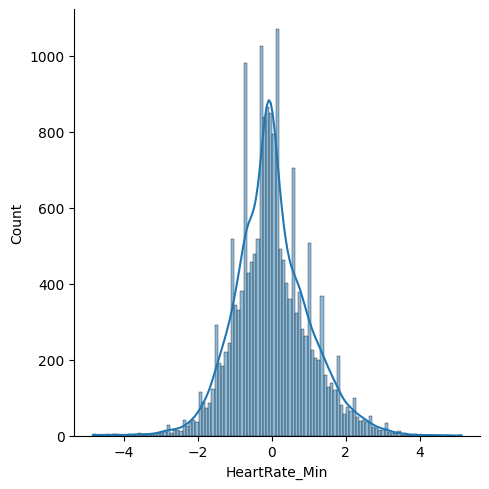

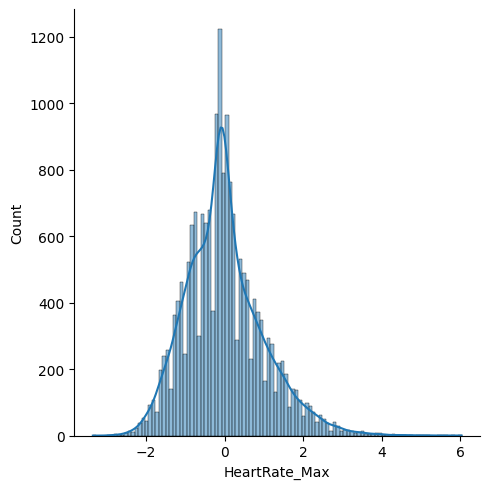

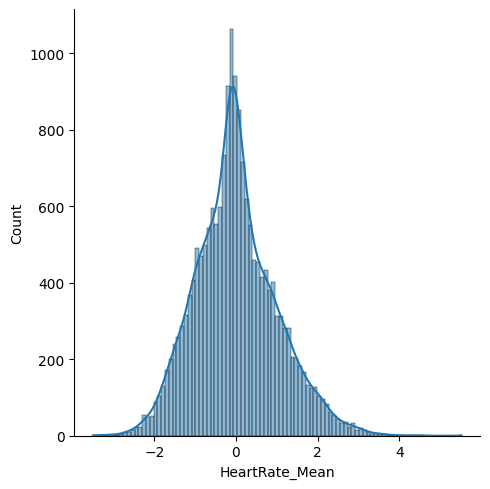

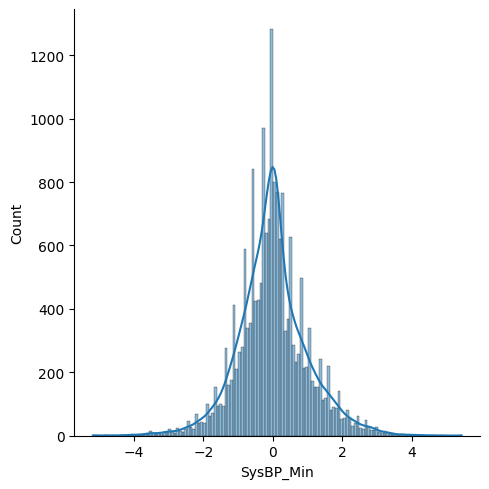

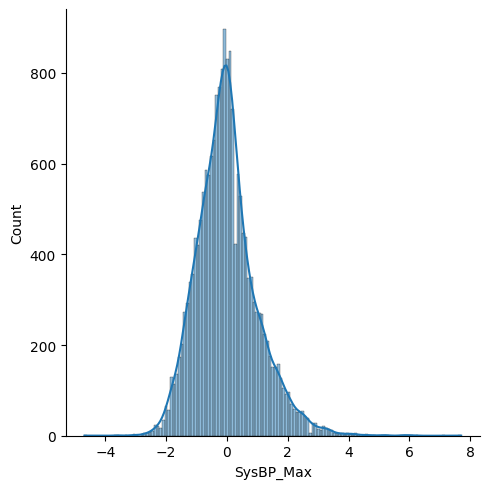

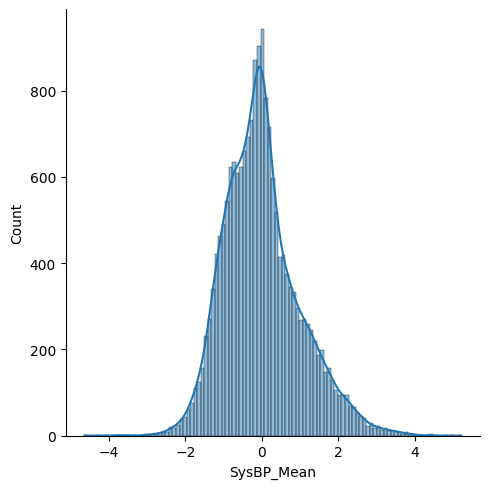

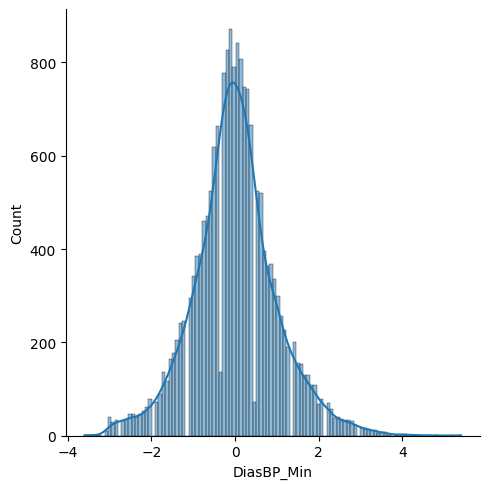

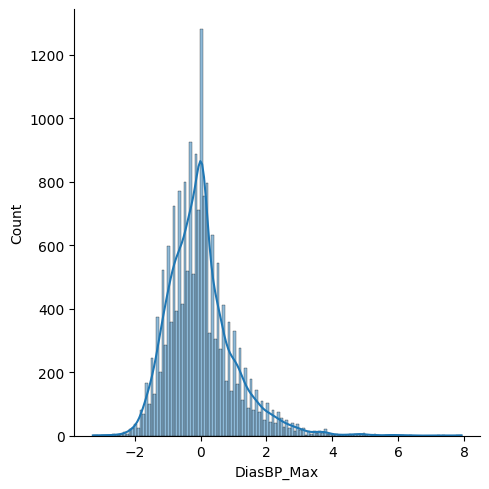

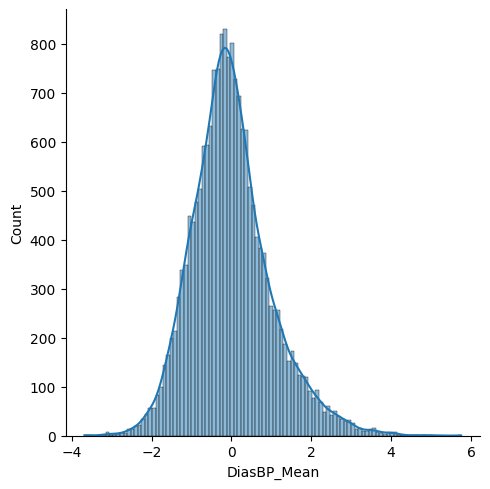

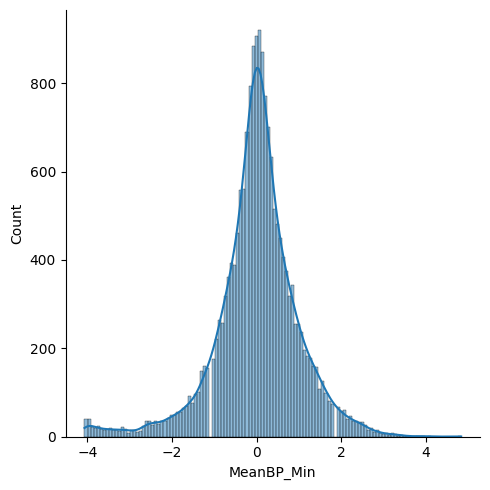

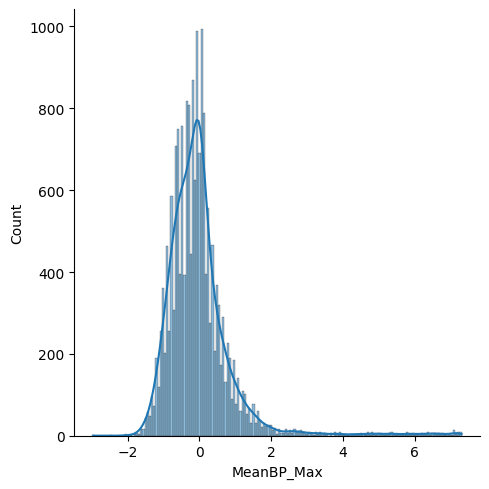

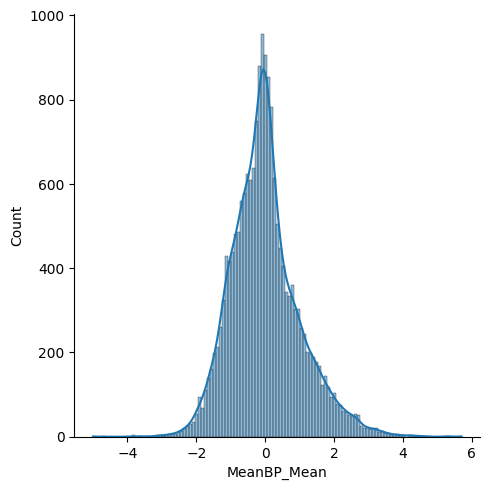

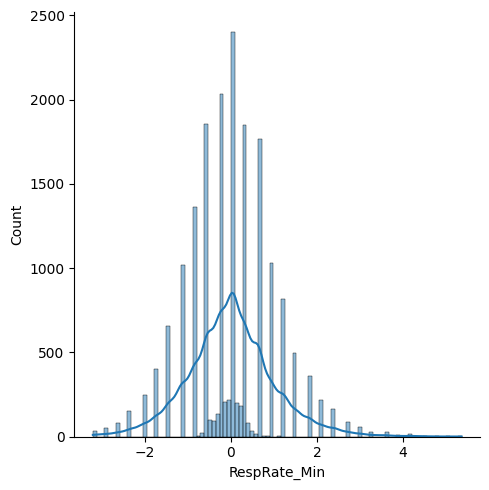

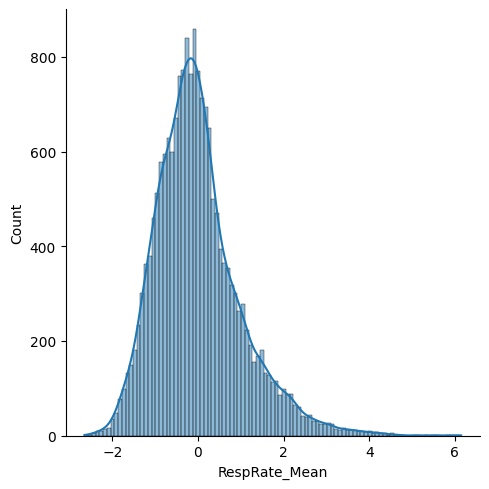

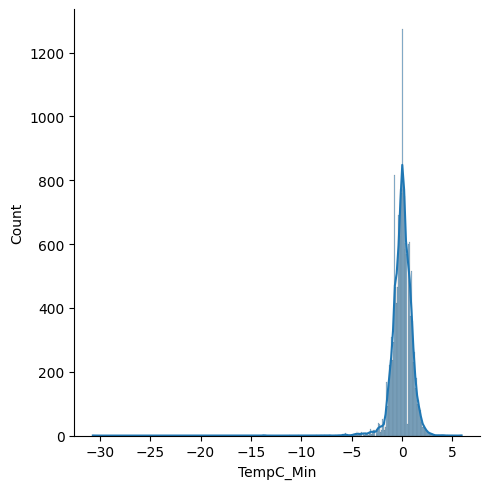

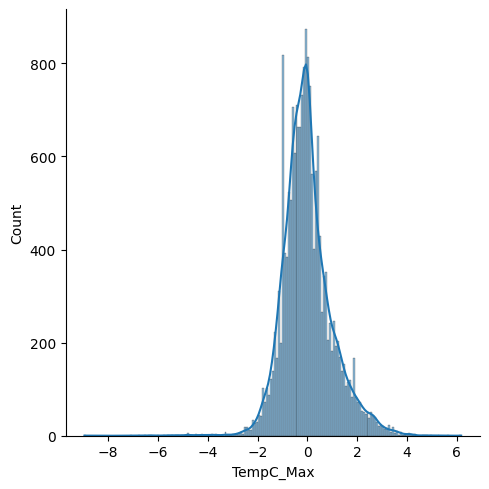

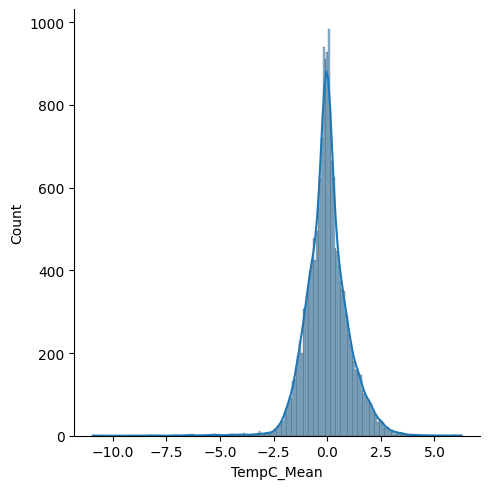

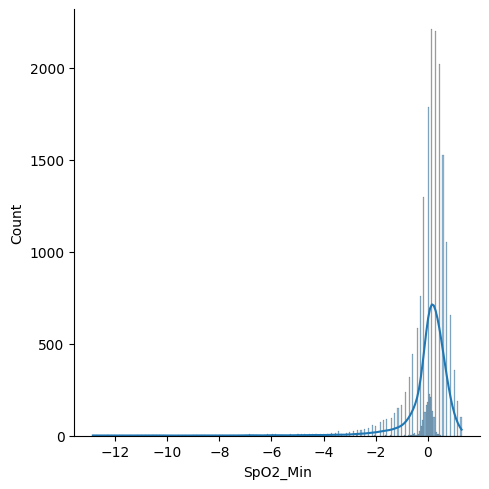

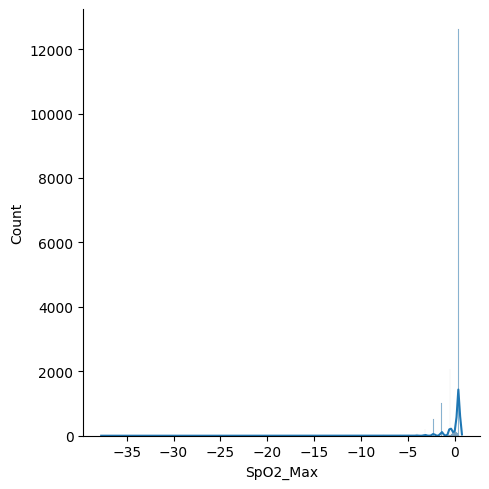

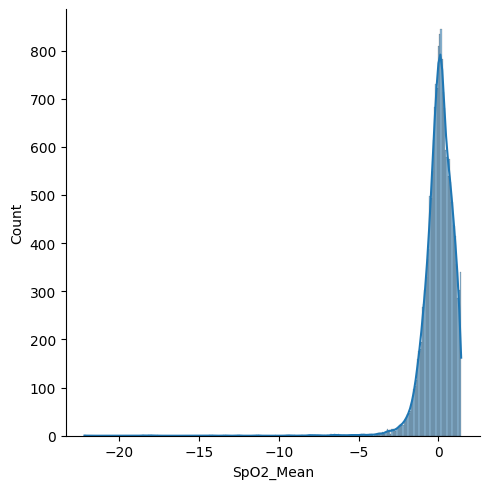

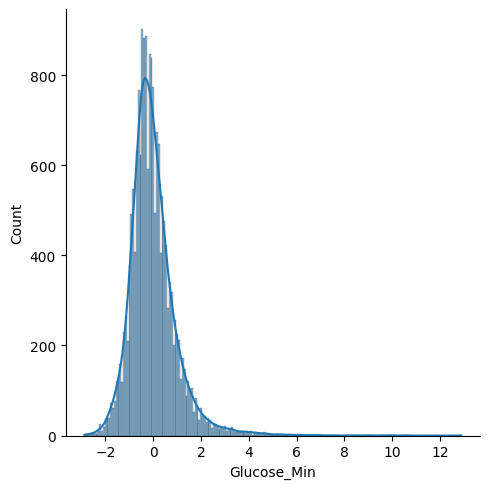

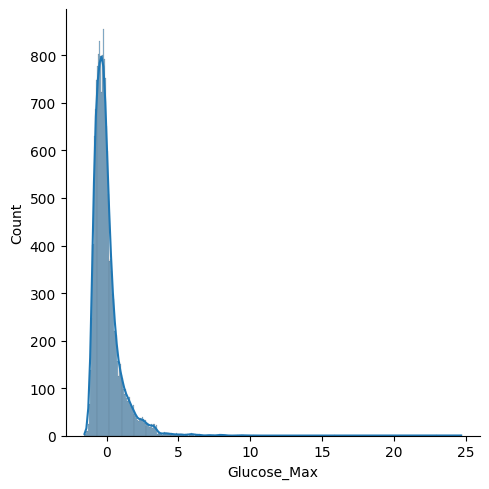

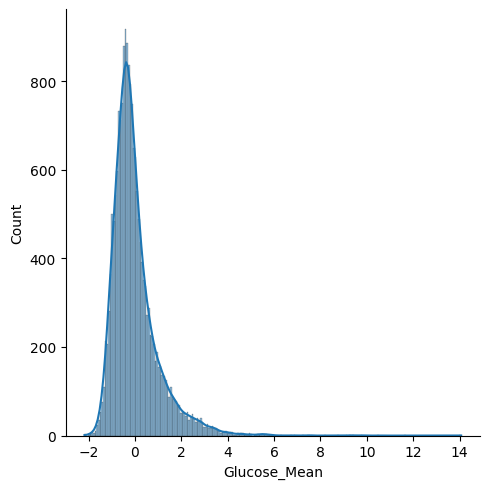

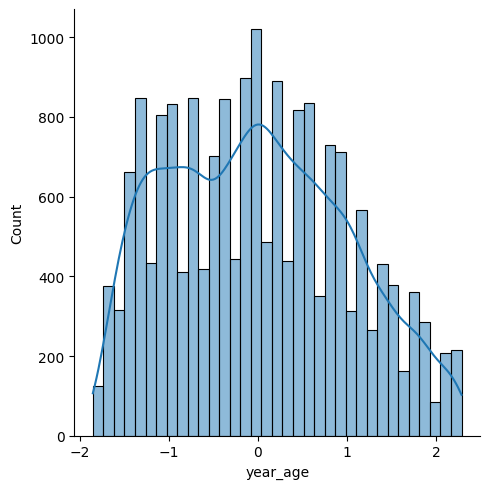

In [66]:
import seaborn as sns
num_variables = ['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean','DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 
'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 
'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'year_age']
#num_variables = ['Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'year_age']

for i in num_variables:
    sns.displot(X_train[i], kde=True)

Reduce Dimensionality

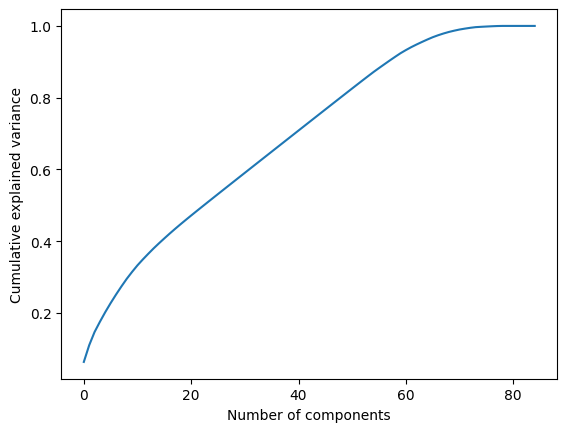

In [67]:
# To determine how many components I will pick, I will pick in terms of variance explained:
import matplotlib.pyplot as plt
pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

Decided not to implement PCA as despite the score of my training set increase, the predict_proba in my X_test worked much worst

Once scaled, I fit my model

In [68]:
MyKNN = KNeighborsClassifier(algorithm='brute') #, metric=lambda X, Y: mydist(X, Y))

k_vals = [1, 2, 5, 10, 20, 40, 60, 80, 160] 
weights = ['uniform', 'distance']

grid_values = {'n_neighbors':k_vals, 'weights':weights}
grid_knn = GridSearchCV(MyKNN, param_grid=grid_values, scoring='roc_auc', cv=20) 

Check how balance is my target variable.

<Axes: >

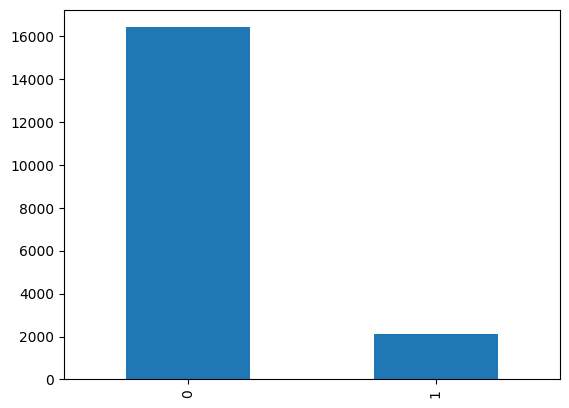

In [69]:
train[y_var].value_counts().plot(kind="bar")

In [70]:
from imblearn.under_sampling import  RandomUnderSampler, ClusterCentroids, AllKNN, CondensedNearestNeighbour, InstanceHardnessThreshold
from imblearn.under_sampling import TomekLinks, NearMiss, NeighbourhoodCleaningRule, OneSidedSelection
from imblearn.over_sampling import SMOTE
oversampler=SMOTE()
#X_p_o, y_train_o = oversampler.fit_resample(X_train, train[y_var])
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, train[y_var])

In [71]:
X_resampled.shape

(4198, 85)

In [72]:
X_p_o.shape

(32824, 85)

In [73]:
#grid_knn.fit(X_train, train[y_var])
grid_knn.fit(X_resampled,y_resampled)
#grid_knn.fit(X_p_o, y_train_o)

GridSearchCV(cv=20, estimator=KNeighborsClassifier(algorithm='brute'),
             param_grid={'n_neighbors': [1, 2, 5, 10, 20, 40, 60, 80, 160],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc')

best parameters: {'n_neighbors': 160, 'weights': 'distance'}
best score:      0.89931 (+/-0.02586)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,...,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,mean_test_score,std_test_score,rank_test_score
17,0.005614,0.000607,0.019991,0.001198,160,distance,"{'n_neighbors': 160, 'weights': 'distance'}",0.884898,0.893968,0.916825,...,0.921179,0.872472,0.909478,0.861315,0.859592,0.888095,0.925366,0.899313,0.025860,1
16,0.005391,0.000686,0.021757,0.002017,160,uniform,"{'n_neighbors': 160, 'weights': 'uniform'}",0.884717,0.892290,0.915057,...,0.920907,0.870295,0.907846,0.862948,0.860363,0.886584,0.924038,0.898570,0.025785,2
15,0.005263,0.000482,0.012569,0.000429,80,distance,"{'n_neighbors': 80, 'weights': 'distance'}",0.869932,0.896417,0.907302,...,0.907392,0.870930,0.897687,0.866122,0.857687,0.882875,0.918773,0.894967,0.025969,3
14,0.005475,0.000483,0.014136,0.002133,80,uniform,"{'n_neighbors': 80, 'weights': 'uniform'}",0.868390,0.895964,0.903628,...,0.906803,0.870023,0.897052,0.868435,0.859002,0.879945,0.917720,0.894203,0.026439,4
13,0.005300,0.000489,0.010863,0.000751,60,distance,"{'n_neighbors': 60, 'weights': 'distance'}",0.866304,0.891519,0.909660,...,0.897868,0.864853,0.896417,0.865215,0.851610,0.882326,0.909524,0.890382,0.025365,5
12,0.005665,0.001473,0.011333,0.001298,60,uniform,"{'n_neighbors': 60, 'weights': 'uniform'}",0.863220,0.889342,0.907302,...,0.897234,0.862540,0.895283,0.868163,0.854059,0.879075,0.906090,0.889050,0.025789,6
11,0.005604,0.000618,0.009772,0.001443,40,distance,"{'n_neighbors': 40, 'weights': 'distance'}",0.857506,0.885351,0.901043,...,0.895420,0.854331,0.882630,0.854875,0.846304,0.884890,0.903846,0.883636,0.025745,7
10,0.005234,0.000468,0.009259,0.000493,40,uniform,"{'n_neighbors': 40, 'weights': 'uniform'}",0.855238,0.880862,0.895873,...,0.894921,0.853152,0.878866,0.858458,0.849161,0.882143,0.902198,0.881843,0.026443,8
9,0.005376,0.000656,0.007075,0.000663,20,distance,"{'n_neighbors': 20, 'weights': 'distance'}",0.837460,0.885714,0.894059,...,0.875465,0.840544,0.867846,0.809705,0.840499,0.878388,0.888645,0.871510,0.027948,9
8,0.005393,0.000576,0.007169,0.000617,20,uniform,"{'n_neighbors': 20, 'weights': 'uniform'}",0.833469,0.878458,0.886122,...,0.871973,0.836780,0.864989,0.810794,0.841542,0.874634,0.881914,0.868292,0.028311,10


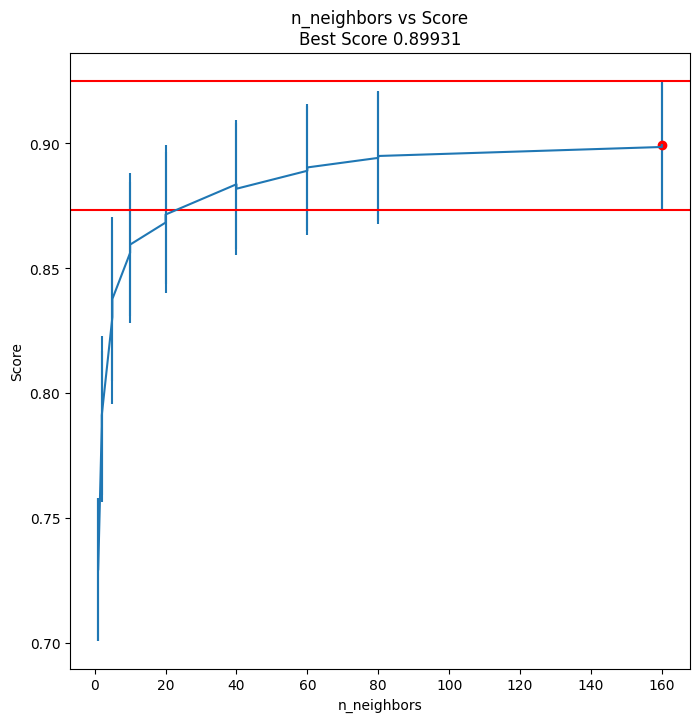

In [74]:
GridSearch_table_plot(grid_knn, "n_neighbors", negative=False, display_all_params=False)

In [75]:
print('best parameters:', grid_knn.best_params_)
print('best score:', grid_knn.best_score_)

best parameters: {'n_neighbors': 160, 'weights': 'distance'}
best score: 0.8993125327053898


SVM Model

In [ ]:
#Fit the model
MySvm = svm.SVC(probability=True)
grid_values = {'C':[0.01, 0.1, 1, 10], 'gamma':[0.01, 0.1, 0.5, 1, 5, 10],'kernel':['linear', 'poly', 'rbf'], 'class_weight':['balanced']}
grid_svm = GridSearchCV(MySvm, param_grid=grid_values, scoring='roc_auc', cv=5, n_jobs=7)
grid_model = grid_svm.fit(X_train, train[y_var])

In [ ]:
# Check performance
GridSearch_table_plot(grid_model, "kernel", negative=False, display_all_params=False)

In [ ]:
print('best parameters:', grid_model.best_params_)
print('best score:', grid_model.best_score_)

In [76]:
# Produce .csv for kaggle testing 
predictions_knn = grid_knn.predict_proba(X_test)
data_test = pd.read_csv('mimic_test_death.csv')['icustay_id']
test_predictions_submit_knn = pd.DataFrame({"icustay_id": data_test, "HOSPITAL_EXPIRE_FLAG": pd.DataFrame(predictions_knn)[1]})
test_predictions_submit_knn.to_csv("Marcelo_Ghia_KNN-undersampling_last_14.csv", index = False)

In [ ]:
# Produce .csv for kaggle testing 
predictions_SVM = grid_model.predict_proba(X_test)
data_test = pd.read_csv('mimic_test_death.csv')['icustay_id']
test_predictions_submit_SVM = pd.DataFrame({"icustay_id": data_test, "HOSPITAL_EXPIRE_FLAG": pd.DataFrame(predictions_SVM)[1]})
test_predictions_submit_SVM.to_csv("Marcelo_Ghia_SVM-undersampling_last_3.csv", index = False)